<center>
    <h1>Blind Source Separation</h1>
    <h2>Deep Learning exam - 29 July 2022</h2>
    <h3>Enrico Pittini 0001036908</h3>
</center>

The task consists in decomposing an image obtained as a sum of a two images img1 and img2 into its components.

The network takes in input the sum img1+img2 and returns the predicted components hat_img1 and hat_img2.

No preprocessing is allowed.

## DATASET

In [1]:
import numpy as np
from tensorflow.keras.datasets import mnist, fashion_mnist
import matplotlib.pyplot as plt

### Loading the MNIST and Fashion MNIST dataset

In [2]:
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()
(fashion_mnist_x_train, fashion_mnist_y_train), (fashion_mnist_x_test, fashion_mnist_y_test) = fashion_mnist.load_data()
print()

print('Shape MNIST train:', np.shape(mnist_x_train))
print('Shape Fashion MNIST train:', np.shape(fashion_mnist_x_train))
print()

# Normalization and Padding
mnist_x_train = np.pad(mnist_x_train,((0,0),(2,2),(2,2)))/255.
mnist_x_test = np.pad(mnist_x_test,((0,0),(2,2),(2,2)))/255.
print('Shape MNIST train after padding:', np.shape(mnist_x_train))
fashion_mnist_x_train = np.pad(fashion_mnist_x_train,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_test = np.pad(fashion_mnist_x_test,((0,0),(2,2),(2,2)))/255.
print('Shape Fashion MNIST train after padding:', np.shape(mnist_x_train))

4431872/4422102 [==============================] - 0s 0us/step

Shape MNIST train: (60000, 28, 28)
Shape Fashion MNIST train: (60000, 28, 28)

Shape MNIST train after padding: (60000, 32, 32)
Shape Fashion MNIST train after padding: (60000, 32, 32)


In [ ]:
print(f'Number of MNIST/fashion MNIST training samples: {np.shape(mnist_x_train)[0]}')
print(f'Number of MNIST/fashion MNIST test samples: {np.shape(mnist_x_test)[0]}')
print(f'MNIST/fashion MNIST resolution: {np.shape(mnist_x_test)[1:]}')

Number of MNIST/fashion MNIST training samples: 60000
Number of MNIST/fashion MNIST test samples: 10000
MNIST/fashion MNIST resolution: (32, 32)


In [3]:
N_train, h, w = mnist_x_train.shape[0], mnist_x_train.shape[1], mnist_x_train.shape[2]
N_test = mnist_x_test.shape[0]

### Data generator
Generator which generates batches. A batch is a couple `x_batch, y_batch`, containing `batchsize` number of samples. `x_batch` represents the input, and it contains images `x`: each image `x` has spatial dimensions $32*32$ and it contains a pair of MNIST-fashion MNIST images added together. `y_batch` represents the ground truth, and it contains the images `y`: each image `y` has spatial dimensions $32*64$ and it contains the same pair of MNIST-fashion MNIST images concatenated along the width.

In [4]:
def datagenerator(x1, x2, batchsize):
    # x1: first dataset of images. In our case, MNIST dataset (either train or test)
    # x2: second dataset of images. In our case, fashion MNIST dataset (either train or test)

    n1 = x1.shape[0]
    n2 = x2.shape[0]
    while True:
        num1 = np.random.randint(0, n1, batchsize)
        num2 = np.random.randint(0, n2, batchsize)

        x_batch = (x1[num1] + x2[num2]) / 2.0
        y_batch = np.concatenate((x1[num1], x2[num2]), axis=2)

        yield x_batch, y_batch 

In [5]:
batchsize = 64

In [6]:
# Generator for creating the training batches
train_generator = datagenerator(mnist_x_train, fashion_mnist_x_train, batchsize)

# Generator for creating the validation batches
test_generator = datagenerator(mnist_x_test, fashion_mnist_x_test, batchsize)

### Example of a batch
Example of a training batch

In [ ]:
x_batch, y_batch = next(train_generator)
print('Shape of the x_batch:', x_batch.shape)
print('Shape of the y_batch:', y_batch.shape)

Shape of the x_batch: (64, 32, 32)
Shape of the y_batch: (64, 32, 64)


The data is already normalized into $[0,1]$

In [ ]:
x_batch[0].min(), x_batch[0].max()

(0.0, 0.696078431372549)

In [ ]:
y_batch[0].min(), y_batch[0].max()

(0.0, 1.0)

Visualization of a sample in the batch

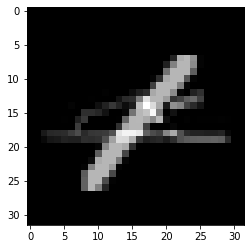

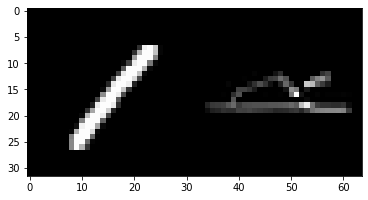

In [ ]:
x = x_batch[0]  # Input
y = y_batch[0]  # Ground truth
plt.imshow(x,cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y, cmap='gray', interpolation='nearest')
plt.show()

## UTILITIES

In [46]:
def plot_history(training_history, n_epochs=None):
    """Plot the training history
  
    Parameters
    ----------
    training_history : dict
    n_epochs : int, optional

    """
    if not n_epochs:
      n_epochs = len(training_history.history['loss'])

    epochs = range(1,n_epochs+1)

    plt.plot(epochs, training_history.history['loss'], label='train_loss')
    plt.plot(epochs, training_history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.title('Loss')

In [47]:
def compute_final_score(model):
  """Compute the final score of the given model.

  Namely, it computes the min MSE, the mean MSE and the std.

  Parameters
  ----------
  model : tf.Model

  Returns
  -------
  min_mse : float
  mean_mse : float
  std_mse : float
  
  """
  test_generator = datagenerator(mnist_x_test, fashion_mnist_x_test, 20000)
  mse_list = []
  for i in range(10):
    x_batch, y_batch = next(test_generator)
    mse = model.evaluate(x_batch, y_batch)
    mse_list.append(mse)
  min_mse = min(mse_list)
  mean_mse = np.mean(mse_list)
  std_mse = np.std(mse_list)
  return min_mse, mean_mse, std_mse

## MODEL: FIRST ATTEMPTS
Before the final model, the following models have been tried. *Disclaimer: this is only a brief sum-up.*
1. **Convolutional autoencoder**. Fully convolutional autoencoder, with one single encoder and one single decoder, which produces both the MNIST and fashion MNIST images at the same time. Input: $32*32*1$. Output: $32*64*1$.
2. **Two-branches convolutional autoencoder**. Fully convolutional autoencoder, with one single encoder and two decoders: one for producing the MNIST image, and one for producing the fashion MNIST image. Input: $32*32*1$. Two outputs $32*32*1$, which are concatenated together along the width, producing a single output $32*64*1$. Convolutional autoencoder with two decoders/branches.
3. **Two-branches U-Net**. U-Net (i.e. fully convolutional autoencoder with skip connections), with one single encoder and two decoders: one for producing the MNIST image, and one for producing the fashion MNIST image. Input: $32*32*1$. Two outputs $32*32*1$, which are concatenated together along the width, producing a single output $32*64*1$. U-net with two decoders/branches.
4. **Single branch U-Net**. U-Net with one single encoder and one decoder (single branch): classic U-Net. It computes only a single image: the fashion MNIST image. Then, the MNIST image is obtained by simply subtracting from the input image the computed fashion MNIST image. Finally, the output of the network is the concatenation between the MNIST image and the fashion MNIST image along the width, obtaining a single output $32*64*1$.

*Remark: the single-branch U-Net produces directly the fashion MNIST image and not the MNIST image because the network performs better in this way. For some reason, it is harder for the U-Net to separate the MNIST digit from the input than separating the fashion MNIST digit from the input.*




| Model                                  | Parameters | MSE    |
| :------------------------------------- | ---------: | -----: |
| Convolutional autoencoder                            | 47,617     | 0.0240 |
| Two-branches convolutional autoencoder | 337,570    | 0.0062 |
| Two-branches U-Net                                  | 157,410    | 0.00049 |
| Single-branch U-Net                                  | 11,261,121    | 0.00038 |

Regarding the U-Net, several different variants have been tried. Let's point out some of the design choices.
- Initial number of channels.
- Number of downsampling-upsampling floors.
- Max Pooling vs strided convolution for downsampling.
- Transposed convolution vs interpolation for upsampling.
- Usage of batch normalization, different activation functions, dropout, ... .
- Usage of different networks as backbones, like vgg16 or vgg19. 

In addition, different U-Net implementations are tried. An interesting implementation which has been tried is the one found in this [repository](https://github.com/MrGiovanni/UNetPlusPlus). It is an interesting implementation, in which you can easily specify many things, like the backbone of interest. 

## FINAL MODEL
The final model is the **Attention U-net**, which is an improvement of the classic U-Net.

This improvement consists in adding an attention mechanism in each skip connection: the network learns in which part of the skip connection focus.

The intuition is the following. For each upsampling block, the input is the concatenation of the output of the previous block with the skip connection from the corresponding downsampling block. The skip connection has great spatial information, but poor semantic information; while the output of the previous block has great semantic information, and poor spatial information. The attention mechanism is applied on the skip connection: using the output of the previous block (the *gating signal*) the network focuses only on the portion of the skip connection which is semantically important. The network learns to focus only on the relevant part of the skip connection. 

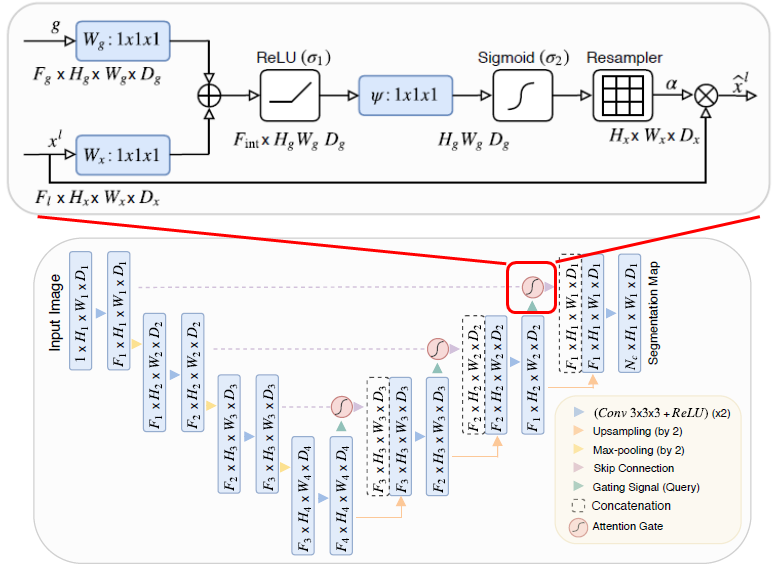

The implementation of the Attention U-Net has been taken from this [repository](https://github.com/bnsreenu/python_for_microscopists/blob/master/224_225_226_models.py). The author of this repository has also made a very clear explanation of the attention U-Net in this [video](https://www.youtube.com/watch?v=KOF38xAvo8I&t=154s).

Some modifications on the architecture have been made. For example, we use three downsampling-upsampling blocks instead of four.

We use the same strategy explained before: single-branch attention U-Net. Single branch/decoder, producing only the fashion MNIST image, while the other MNIST image is simply computed by subtracting the fashion MNIST image from the input. Input: $32*32*1$. Output: $32*64*1$.

*Remark: the single-branch attention U-Net produces directly the fashion MNIST image and not the MNIST image because the network performs better in this way, as said before.*

In [7]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K

### Insights
In the next sections, the final best model and the final best training are shown. For finding this best path, several decisions and hyperparameters tuning have been carried out. Let's point out some of these choices.
- Initial number of channels. (The best one is $64$).
- Number of downsampling-upsampling floors. (The best one is $3$).
- Batch size and number of steps per epoch.
- Max Pooling vs strided convolution for downsampling. (Max pooling is better).
- Transposed convolution vs interpolation for upsampling. (Interpolation is better).
- Usage of batch normalization, different activation functions, dropout, ... . (Batch normalization improves the situation, relu is the best activation function, dropout does not improve the situation, ...).
- Two branches-decoders vs one single branch-decoder. (One single decoder is better).

### Functions for building the model

In [8]:
def conv_block(x, filter_size, size, dropout, batch_norm=False):
    """Build a convolutional block and return its output.

    A convolutional block consists in a sequence of convolutional layers. It is the basic unit for building the U-Net.

    Parameters
    ----------
    x : tf.Tensor
        Input
    filter_size : int
        Size of the filters in the convolutional layers
    size : int
        Number of filters in the convolutional layers
    dropout : float
        Amount of dropout
    batch_norm : bool, optional
        Whether to use or not Batch Normalization, by default False

    Returns
    -------
    tf.Tensor
        Output of the convolutional block
        
    """    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    return conv

In [9]:
def repeat_elem(tensor, rep):
     """Lambda function to repeat the elements of a tensor along an axis by a factor of `rep`.

     If tensor has shape (None, 256,256,3), lambda will return a tensor of shape (None, 256,256,6), if specified axis=3 and 
     rep=2.

     Parameters
     ----------
     tensor : tf.Tensor
     rep : int

     Returns
     -------
     tf.Tensor

     """
     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)

In [10]:
def gating_signal(input, out_size, batch_norm=False):
    """Resize the given tensor in order to have `out_size` channels, and same spatial dimensions.

    This is applied for applying the attention mechanism in an upsampling block, for making the channels dimension of the gating 
    signal (i.e. output of the previous block) equal to the channels dimension of the skip connection

    Parameters
    ----------
    input : tf.Tensor
        Given tensor
    out_size :int
        Number of channels
    batch_norm : bool, optional
        Whether to use or not Batch Normalization, by default False

    Returns
    -------
    tf.Tensor
    
    """
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

In [11]:
def attention_block(x, gating, inter_shape):
    """Build an attention block and return its output.

    Parameters
    ----------
    x : tf.Tensor
        Tensor on which apply the attention mechanism. In our case, it is the skip connection.
    gating : tf.Tensor
        Tensor used for applying the attention. In our case, it is the output of the previous upsample block.
    inter_shape : int
        Number of channels in the attention block

    Notes
    ----------
    It is assumed that the `gating` has already same channels dimension of `x`, thanks to the application of the function ``

    """
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

    # Getting the x signal to the same shape as the gating signal
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

    # Getting the gating signal to the same number of filters as the inter_shape
    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn

In [12]:
def Attention_UNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):
    """Build and return the attention U-Net.

    Parameters
    ----------
    input_shape : tuple
        Tuple of the form (h, w, c): height, width, number of channels.
    NUM_CLASSES : int, optional
        Number of classes, by default 1
    dropout_rate : float, optional
        Amount of dropout, by default 0.0
    batch_norm : bool, optional
        Whether to use or not Batch Normalization, by default False

    Returns
    -------
    tf.Model

    """
    # Network structure
    FILTER_NUM = 64 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    
    inputs = layers.Input(input_shape, dtype=tf.float32)

    # DOWNSAMPLING (i.e. ENCODER)
    # Down 1
    conv_128 = conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # Down 2
    conv_64 = conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # Down 3
    conv_32 = conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # Encoding
    conv_16 = conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)

    # UPSAMPLING (i.e. DECODER)
    # Up 1
    gating_32 = gating_signal(conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_16)  
    up_32 = layers.concatenate([up_32, att_32], axis=3)
    up_conv_32 = conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # Up 2
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=3)
    up_conv_64 = conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # Up 3
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=3)
    up_conv_128 = conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
    # We produce the fashion MNIST digit
    y2 = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    y2 = layers.BatchNormalization(axis=3)(y2)
    y2 = layers.Activation('sigmoid')(y2)  

    # We compute the MNIST digit by simply subtracting y2 from the input
    y1 = 2*inputs - y2

    # Final output: concatenation of y1 and y2 along the width. 
    # Dimensions 32*64*1
    y = layers.concatenate([y1, y2], axis=2)

    model = models.Model(inputs, y, name="Attention_UNet")
    return model

### Building the model

In [13]:
att_unet = Attention_UNet(input_shape=(32,32,1), NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True)

In [14]:
att_unet.summary()

Model: "Attention_UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   640         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 32, 32, 64)   0           ['batch_normalizatio

$9M$ parameters.

## TRAINING
We use:
- $64$ as batch size;
- $10000$ as steps per epoch;
- $15$ as number of epochs;
- MSE as loss function;
- Adam as optimizer, with initial learning rate $1*10^{-3}$;
- reduce learning rate on plateau strategy;
- test generator as validation data, with validation steps equal to $156$ ($156$ is equal to the integer division between the number of samples in the test set and the batch size).

In [15]:
from tensorflow.keras.optimizers import Adam

In [16]:
att_unet.compile(optimizer=Adam(), loss='mse')

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
reduce_lr_callback = ReduceLROnPlateau(patience=3, min_delta=0.00001)

callback_checkpoint = ModelCheckpoint('ATT_UNET.{epoch:02d}-{val_loss:.4f}.hdf5', save_weights_only=True) 

In [18]:
steps_per_epoch = 10000
val_steps = N_test // batchsize

In [ ]:
hist = att_unet.fit(train_generator, epochs=15, batch_size=batchsize, validation_data=test_generator, callbacks=[callback_checkpoint,reduce_lr_callback],
              steps_per_epoch=steps_per_epoch, validation_steps=val_steps)

Epoch 1/15
10000/10000 [==============================] - 488s 48ms/step - loss: 0.0067 - val_loss: 8.6514e-04 - lr: 0.0010
Epoch 2/15
10000/10000 [==============================] - 478s 48ms/step - loss: 7.3294e-04 - val_loss: 6.0036e-04 - lr: 0.0010
Epoch 3/15
10000/10000 [==============================] - 476s 48ms/step - loss: 5.9117e-04 - val_loss: 5.3404e-04 - lr: 0.0010
Epoch 4/15
10000/10000 [==============================] - 482s 48ms/step - loss: 5.2961e-04 - val_loss: 5.2938e-04 - lr: 0.0010
Epoch 5/15
10000/10000 [==============================] - 501s 50ms/step - loss: 4.9181e-04 - val_loss: 4.6700e-04 - lr: 0.0010
Epoch 6/15
10000/10000 [==============================] - 495s 49ms/step - loss: 4.6742e-04 - val_loss: 4.5617e-04 - lr: 0.0010
Epoch 7/15
10000/10000 [==============================] - 508s 51ms/step - loss: 4.4637e-04 - val_loss: 4.7722e-04 - lr: 0.0010
Epoch 8/15
10000/10000 [==============================] - 510s 51ms/step - loss: 4.3479e-04 - val_loss: 4.30

*It is important to notice that the `reduceLROnPlateau` callback has not been activated yet.*

Let's compute the final score.

In [50]:
min_mse, mean_mse, std_mse = compute_final_score(att_unet)
print('Min:', min_mse)
print('Mean:', mean_mse)
print('Std:', std_mse)

625/625 [==============================] - 7s 11ms/step - loss: 3.8049e-04
Min: 0.00037918068119324744
Mean: 0.00038211256614886226
Std: 2.130476315472836e-06


Min score: $0.000379$. Mean score: $0.000382$. Std: $2.13*10^{-6}$.

Let's plot the evolution of the mse.

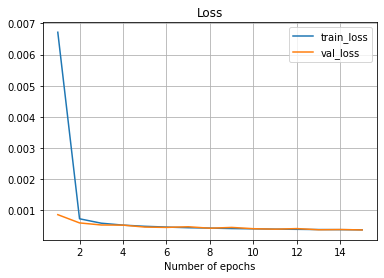

In [ ]:
plot_history(hist)

Pefect curve! No overfitting!

### More training

$10$ more epochs.

In [ ]:
hist = att_unet.fit(train_generator, epochs=10, batch_size=batchsize, validation_data=test_generator, callbacks=[callback_checkpoint,reduce_lr_callback],
              steps_per_epoch=steps_per_epoch, validation_steps=val_steps)

Epoch 1/10
10000/10000 [==============================] - 504s 50ms/step - loss: 3.7467e-04 - val_loss: 4.3410e-04 - lr: 0.0010
Epoch 2/10
10000/10000 [==============================] - 504s 50ms/step - loss: 3.6844e-04 - val_loss: 3.7797e-04 - lr: 0.0010
Epoch 3/10
10000/10000 [==============================] - 505s 50ms/step - loss: 3.6314e-04 - val_loss: 3.6720e-04 - lr: 0.0010
Epoch 4/10
10000/10000 [==============================] - 499s 50ms/step - loss: 3.6095e-04 - val_loss: 3.6929e-04 - lr: 0.0010
Epoch 5/10
10000/10000 [==============================] - 499s 50ms/step - loss: 3.5695e-04 - val_loss: 3.6167e-04 - lr: 0.0010
Epoch 6/10
10000/10000 [==============================] - 508s 51ms/step - loss: 3.5492e-04 - val_loss: 3.5648e-04 - lr: 0.0010
Epoch 7/10
10000/10000 [==============================] - 493s 49ms/step - loss: 3.5284e-04 - val_loss: 3.5898e-04 - lr: 0.0010
Epoch 8/10
10000/10000 [==============================] - 513s 51ms/step - loss: 3.4897e-04 - val_loss: 

*The `reduceLROnPlateau` has been activated on the last epoch.*

Let's compute the final score.

In [52]:
min_mse, mean_mse, std_mse = compute_final_score(att_unet)
print('Min:', min_mse)
print('Mean:', mean_mse)
print('Std:', std_mse)

625/625 [==============================] - 7s 11ms/step - loss: 3.3377e-04
Min: 0.00032732324325479567
Mean: 0.00033255403395742177
Std: 2.5349560563843655e-06


Min score: $0.000327$. Mean score: $0.000332$. Std: $2.53*10^{-6}$.

### More training
$7$ more epochs.

In [28]:
from tensorflow.keras.optimizers import Adam
att_unet.compile(optimizer=Adam(0.0001), loss='mse')

In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', min_lr=0.000009, min_delta=0.00001, factor=0.75, patience=2, verbose=1, mode='min')

callback_checkpoint = ModelCheckpoint('ATT_UNET.{epoch:02d}-{val_loss:.4f}.hdf5', save_weights_only=True) 

In [31]:
steps_per_epoch = 10000
val_steps = N_test // batchsize

In [1]:
hist = att_unet.fit(train_generator, epochs=7, batch_size=batchsize, validation_data=test_generator, callbacks=[callback_checkpoint,reduce_lr_callback],
              steps_per_epoch=steps_per_epoch, validation_steps=val_steps)

Epoch 1/7
10000/10000 [==============================] - 529s 51ms/step - loss: 3.2716e-04 - val_loss: 3.2966e-04 - lr: 1.0000e-04
Epoch 2/7
10000/10000 [==============================] - 506s 51ms/step - loss: 3.2510e-04 - val_loss: 3.2436e-04 - lr: 1.0000e-04
Epoch 3/7
10000/10000 [==============================] - ETA: 0s - loss: 3.2342e-04
Epoch 3: ReduceLROnPlateau reducing learning rate to 7.499999810534064e-05.
10000/10000 [==============================] - 505s 50ms/step - loss: 3.2342e-04 - val_loss: 3.2849e-04 - lr: 1.0000e-04
Epoch 4/7
10000/10000 [==============================] - 504s 50ms/step - loss: 3.2229e-04 - val_loss: 3.1964e-04 - lr: 7.5000e-05
Epoch 5/7
10000/10000 [==============================] - 504s 50ms/step - loss: 3.2145e-04 - val_loss: 3.1919e-04 - lr: 7.5000e-05
Epoch 6/7
10000/10000 [==============================] - ETA: 0s - loss: 3.1999e-04
Epoch 6: ReduceLROnPlateau reducing learning rate to 5.6249997214763425e-05.
10000/10000 [=====================

Let's compute the final score.

In [56]:
min_mse, mean_mse, std_mse = compute_final_score(att_unet)
print('Min:', min_mse)
print('Mean:', mean_mse)
print('Std:', std_mse)

625/625 [==============================] - 7s 12ms/step - loss: 3.1165e-04
Min: 0.0003115357249043882
Mean: 0.00031461602193303404
Std: 2.2896727290518663e-06


Min score: $0.0003115$. Mean score: $0.0003146$. Std: $2.29*10^{-6}$.

## FINAL RESULTS
The final results are the following.

| #parameters | #epochs | Min MSE     | Mean MSE | Std MSE |
| ----- | ---- | ----------- | ------- | ------- |
| $9M$      | $32$       | $3.111e-4$ | $3.146e-4$| $2.29e-6$|

Visualization

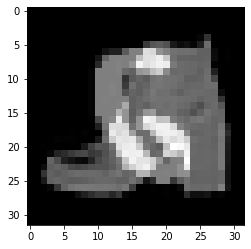

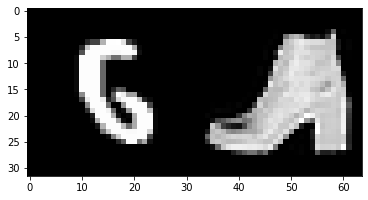

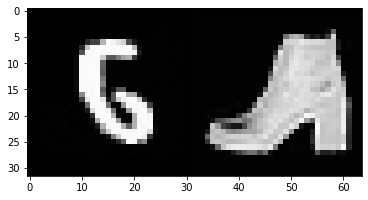

In [ ]:
x_batch, y_batch = next(test_generator)
x = x_batch[0]
y = y_batch[0]
y_pred = att_unet.predict(x.reshape((1,32,32)))
plt.imshow(x,cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y, cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y_pred[0].reshape((32,64)), cmap='gray', interpolation='nearest')
plt.show()